### Load sequences

In [1]:
def rename(label):
    match=re.match('.*_(chr.*)$',label)
    if match:
        return match.group(1)
    else:
        return ""

In [2]:
import re
import gzip

from collections import OrderedDict
def load_sequences(seqfile):
	seqs = OrderedDict()
	fp = gzip.open(seqfile, "rb")
	print("#Loading " + seqfile + " ...")
	expecting = "label"
	label=''
	for line in fp:
		if expecting == "label":
			match = re.match(">(.*)$", line)
			if match:
				label = match.group(1)
				expecting = "sequence"
			else:
				print("Expecting LABEL but found (!!): " + line)
				continue
		else:
			match = re.match("(\w+)$", line)
			if match:
				sequence = match.group(1)
				seqs[label]=sequence
			else:
				print("Expecting SEQUENCE but found (!!): " + line)
			expecting = "label"
			label=''
	fp.close()
	print("#Loaded " + str(len(seqs.keys())) + " sequences from " + seqfile)
	return seqs

In [3]:
def load_sequences_from_bedfile(seqfile):
    seqs = OrderedDict()
    fp = gzip.open(seqfile, "rb")
    print("#Loading " + seqfile + " ...")
    for line in fp:
        (label, sequence)=line.split()
        seqs[label]=sequence
    fp.close()
    print("#Loaded " + str(len(seqs.keys())) + " sequences from " + seqfile)
    return seqs

In [4]:
import h5py
import random
from deeplift import dinuc_shuffle as dn

seqs = load_sequences_from_bedfile('/users/eprakash/projects/benchmarking/newdata/A549/A549.summits.400bp.implanted.5Ksubsample.bed.gz')
print("Implanted seqs have labels like: " + random.choice(seqs.keys()))
unimplantedseqs = load_sequences('/users/eprakash/projects/benchmarking/newdata/A549/A549.summits.400bp.fa.gz')
print("Unmplanted seqs have labels like: " + random.choice(unimplantedseqs.keys()))
ig_pos=h5py.File('/users/eprakash/projects/benchmarking/newdata/A549/models/deepseabeluga/results/top1kposlabels_A549_1kb','r')
ig_pos_labels=list(ig_pos.get("labels"))
print("IG labels are like: " + random.choice(ig_pos_labels))
original_seqs={}
dn_shuff_seqs = {}
for label in ig_pos_labels:
    renamed = rename(label)
    original_seqs.update({renamed:seqs[label]})
    dn_shuff_seqs.update({renamed:dn.dinuc_shuffle(unimplantedseqs[renamed])})
print("Original seqs size is " + str(len(original_seqs)))
print("Dinuc shuffled corresponding seqs size is " + str(len(dn_shuff_seqs)))
        

#Loading /users/eprakash/projects/benchmarking/newdata/A549/A549.summits.400bp.implanted.5Ksubsample.bed.gz ...
#Loaded 5000 sequences from /users/eprakash/projects/benchmarking/newdata/A549/A549.summits.400bp.implanted.5Ksubsample.bed.gz
Implanted seqs have labels like: dinuc_shuffled_motifs_implanted_chr4:150510477-150510877
#Loading /users/eprakash/projects/benchmarking/newdata/A549/A549.summits.400bp.fa.gz ...
#Loaded 143217 sequences from /users/eprakash/projects/benchmarking/newdata/A549/A549.summits.400bp.fa.gz
Unmplanted seqs have labels like: chrX:40552774-40553174
IG labels are like: dinuc_shuffled_motifs_implanted_chr10:71860445-71860845
Original seqs size is 1000
Dinuc shuffled corresponding seqs size is 1000


### Onehot encode data

In [5]:
import numpy as np
original_labels=np.array(original_seqs.keys())
dn_shuff_labels=np.array(dn_shuff_seqs.keys())

In [6]:
#this is set up for 1d convolutions where examples
#have dimensions (len, num_channels)
#the channel axis is the axis for one-hot encoding.
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
#sequences = sequences[-5000:]            
original_onehot_data = np.array([one_hot_encode_along_channel_axis(original_seqs[label]) for label in original_labels])
dn_onehot_data = np.array([one_hot_encode_along_channel_axis(dn_shuff_seqs[label]) for label in dn_shuff_labels])

In [7]:
print(original_onehot_data.shape)
print(dn_onehot_data.shape)

(1000, 400, 4)
(1000, 400, 4)


### Load keras model

In [8]:
import deeplift
from keras.models import model_from_json

#load the keras model
keras_model_weights = "/users/eprakash/projects/benchmarking/newdata/A549/models/deepseabeluga/momma_dragonn/examples/fasta_sequential_model/model_files/record_1_model_SkPDS_modelWeights.h5"
keras_model_json = "/users/eprakash/projects/benchmarking/newdata/A549/models/deepseabeluga/momma_dragonn/examples/fasta_sequential_model/model_files/record_1_model_SkPDS_modelJson.json"
keras_model = model_from_json(open(keras_model_json).read())
keras_model.load_weights(keras_model_weights)

Using TensorFlow backend.


In [9]:
print({i: v for i, v in enumerate(keras_model.layers)})

{0: <keras.layers.convolutional.Conv1D object at 0x7f135f63af90>, 1: <keras.layers.core.Activation object at 0x7f135f65e3d0>, 2: <keras.layers.convolutional.Conv1D object at 0x7f135f65e410>, 3: <keras.layers.core.Activation object at 0x7f135f65ef10>, 4: <keras.layers.core.Dropout object at 0x7f135f5a4cd0>, 5: <keras.layers.pooling.MaxPooling1D object at 0x7f135f603690>, 6: <keras.layers.convolutional.Conv1D object at 0x7f14648c8690>, 7: <keras.layers.core.Activation object at 0x7f135f56e9d0>, 8: <keras.layers.convolutional.Conv1D object at 0x7f135f56e690>, 9: <keras.layers.core.Activation object at 0x7f135f5d5990>, 10: <keras.layers.core.Dropout object at 0x7f135f589c90>, 11: <keras.layers.pooling.MaxPooling1D object at 0x7f135f5a13d0>, 12: <keras.layers.convolutional.Conv1D object at 0x7f135f65e390>, 13: <keras.layers.core.Activation object at 0x7f135f5a1450>, 14: <keras.layers.convolutional.Conv1D object at 0x7f135f54f390>, 15: <keras.layers.core.Activation object at 0x7f135f4e4790>,

In [10]:
from keras.models import Model

layer_name = 'd1'
intermediate_layer_model = Model(inputs=keras_model.input,
                                 outputs=keras_model.layers[19].output)
                                 #keras_model.get_layer(layer_name).output)

In [11]:
original_logits = intermediate_layer_model.predict(original_onehot_data)
dn_logits = intermediate_layer_model.predict(dn_onehot_data)

original_logits=np.squeeze(original_logits,axis=1)
dn_logits=np.squeeze(dn_logits,axis=1)

### Interpolation

In [12]:
#alpha=0.01
alpha=0.1

logits=[]

for index in range(0,len(original_seqs)):
    if (index % 10 == 0):
        print("On sequence " + str(index))
    reference=dn_onehot_data[index]
    actual=original_onehot_data[index]
    seq_logits=[]
    for step_number in range(0,int(1/alpha)):
        step_size=alpha*(step_number+1)
        interpolated=(1-step_size)*reference + step_size*actual
        interpolated_logit=intermediate_layer_model.predict(interpolated[None,:])
        seq_logits.append(interpolated_logit)
    logits.append(seq_logits)

On sequence 0
On sequence 10
On sequence 20
On sequence 30
On sequence 40
On sequence 50
On sequence 60
On sequence 70
On sequence 80
On sequence 90
On sequence 100
On sequence 110
On sequence 120
On sequence 130
On sequence 140
On sequence 150
On sequence 160
On sequence 170
On sequence 180
On sequence 190
On sequence 200
On sequence 210
On sequence 220
On sequence 230
On sequence 240
On sequence 250
On sequence 260
On sequence 270
On sequence 280
On sequence 290
On sequence 300
On sequence 310
On sequence 320
On sequence 330
On sequence 340
On sequence 350
On sequence 360
On sequence 370
On sequence 380
On sequence 390
On sequence 400
On sequence 410
On sequence 420
On sequence 430
On sequence 440
On sequence 450
On sequence 460
On sequence 470
On sequence 480
On sequence 490
On sequence 500
On sequence 510
On sequence 520
On sequence 530
On sequence 540
On sequence 550
On sequence 560
On sequence 570
On sequence 580
On sequence 590
On sequence 600
On sequence 610
On sequence 620
On 

In [13]:
logits=np.array(logits)
logits=np.squeeze(logits,axis=3)
logits=np.squeeze(logits,axis=2)

In [14]:
print(logits.shape)

(1000, 10)


### Plot logit distribution

PREDICTIONS DENSITY PLOT


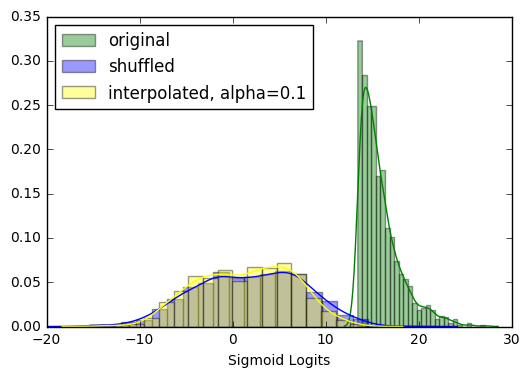

PREDICTIONS DENSITY PLOT


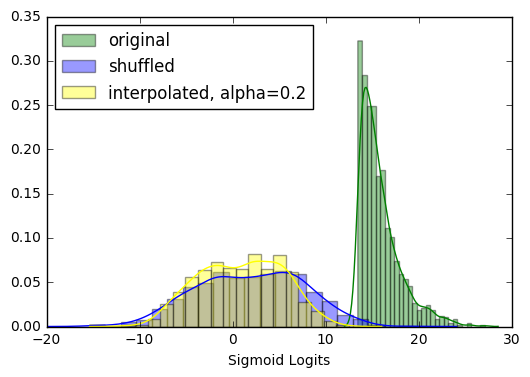

PREDICTIONS DENSITY PLOT


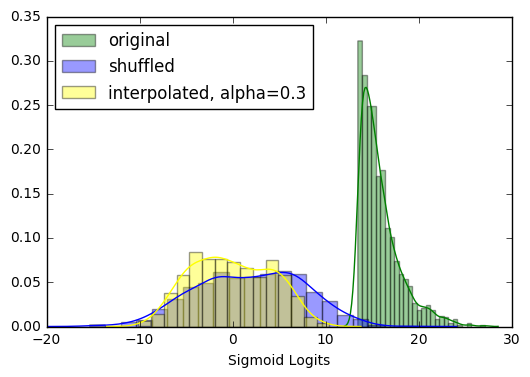

PREDICTIONS DENSITY PLOT


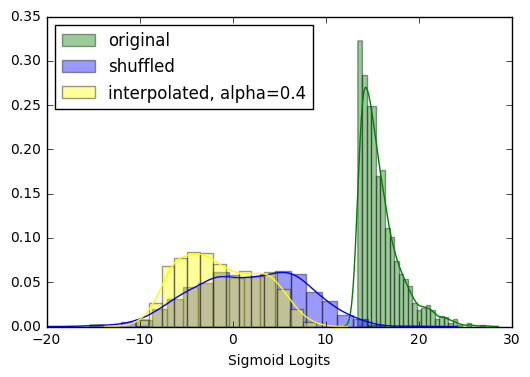

PREDICTIONS DENSITY PLOT


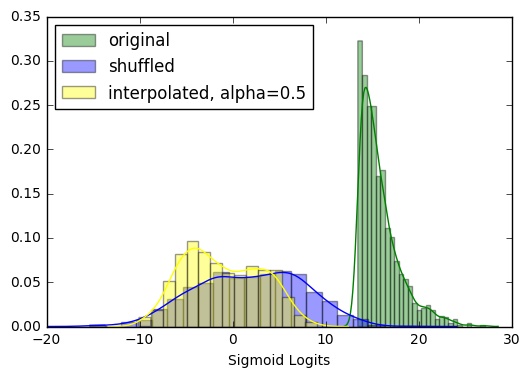

PREDICTIONS DENSITY PLOT


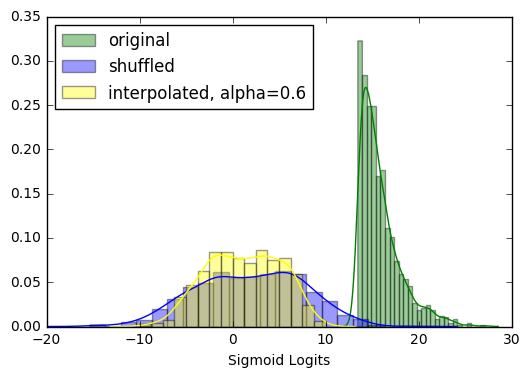

PREDICTIONS DENSITY PLOT


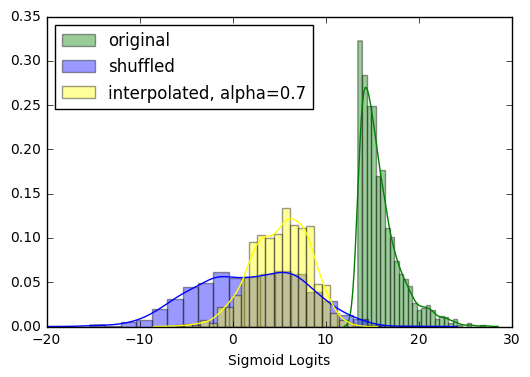

PREDICTIONS DENSITY PLOT


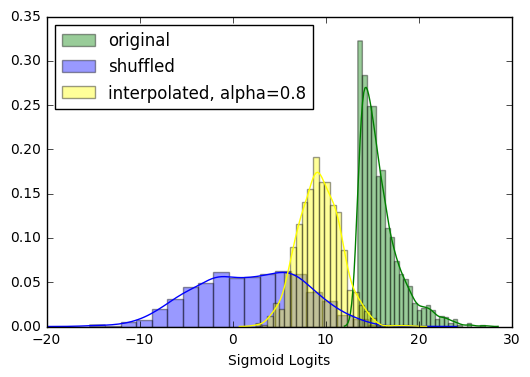

PREDICTIONS DENSITY PLOT


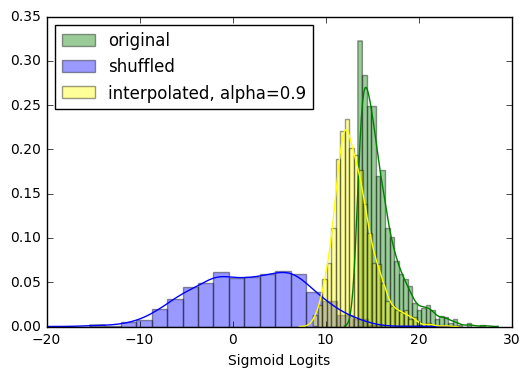

PREDICTIONS DENSITY PLOT


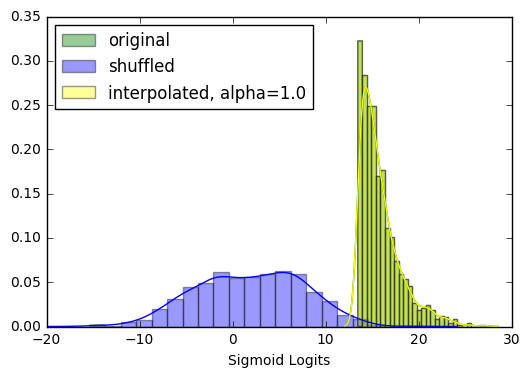

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
for column in range(0,10):
    #column=1
    print("PREDICTIONS DENSITY PLOT")
    sns.distplot(original_logits, color='green', label="original", axlabel="Sigmoid Logits")
    sns.distplot(dn_logits, color='blue', label="shuffled",)
    sns.distplot(logits[:,column], color='yellow', label="interpolated, alpha="+str(alpha*(column+1)))
    plt.legend(loc = 'upper left')
    plt.show()